# Project 3: Web APIs & NLP

In week four we learned about a few different classifiers. In week five we're learning about webscraping, APIs, and Natural Language Processing (NLP). This project will put those skills to the test.

For project 3, your goal is two-fold:
1. Using [PRAW](https://praw.readthedocs.io/en/stable/index.html), you'll collect posts from two subreddits of your choosing.
2. You'll then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem.

## Part 2: Data Cleaning and EDA

We will now take our subreddit data we pulled in Part 1 and do some data cleaning and EDA before we preprocess and model.

In [34]:
# Import packages
import numpy as np
import pandas as pd       
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

In [35]:
# Read in combined dataset from part 1
reddit_data = pd.read_csv('./data/reddit_data.csv')
reddit_data.head()

,Unnamed: 0,created_utc,title,self_text,subreddit,score,num_comments
0,0,1.709228e+09,A ten year old goes out to run errands and nev...,Ten-year-old Mary Ann Verdecchia was excited o...,UnresolvedMysteries,346,39
1,1,1.709215e+09,A Shadow Over Leigh: The Unsolved Murder of 14...,**Background** \nLisa Hession was a 14 year o...,UnresolvedMysteries,217,23
2,2,1.709175e+09,Tera Tracy,Saw this story online and thought it was worth...,UnresolvedMysteries,67,10
3,3,1.709069e+09,The Boy and the Bike: the Disappearance of Dav...,"I know this has been covered a few times, but ...",UnresolvedMysteries,348,54
4,4,1.709053e+09,"A body of a young man is found near a parkway,...",Hello everyone! Thank you for all your comment...,UnresolvedMysteries,231,35


In [36]:
# Drop Unnamed: 0 column
reddit_data.drop(columns = ['Unnamed: 0'], inplace = True)

In [37]:
# Look at the shape of the dataset
reddit_data.shape

(4785, 6)

In [38]:
# Look at the subreddit split
reddit_data["subreddit"].value_counts()

subreddit
FanTheories            2461
UnresolvedMysteries    2324
Name: count, dtype: int64

In [39]:
# Look at the first 5 rows of the dataset
reddit_data.head()

,created_utc,title,self_text,subreddit,score,num_comments
0,1.709228e+09,A ten year old goes out to run errands and nev...,Ten-year-old Mary Ann Verdecchia was excited o...,UnresolvedMysteries,346,39
1,1.709215e+09,A Shadow Over Leigh: The Unsolved Murder of 14...,**Background** \nLisa Hession was a 14 year o...,UnresolvedMysteries,217,23
2,1.709175e+09,Tera Tracy,Saw this story online and thought it was worth...,UnresolvedMysteries,67,10
3,1.709069e+09,The Boy and the Bike: the Disappearance of Dav...,"I know this has been covered a few times, but ...",UnresolvedMysteries,348,54
4,1.709053e+09,"A body of a young man is found near a parkway,...",Hello everyone! Thank you for all your comment...,UnresolvedMysteries,231,35


In [40]:
# Check for null/na values
reddit_data.isna().sum()

created_utc      0
title            0
self_text       57
subreddit        0
score            0
num_comments     0
dtype: int64

In [41]:
# Dropping NA values since it's a small percentage of the dataset
reddit_data = reddit_data.dropna()

In [42]:
# Checking to make sure all NAs were dropped
reddit_data.isna().sum()

created_utc     0
title           0
self_text       0
subreddit       0
score           0
num_comments    0
dtype: int64

In [43]:
# Checking how many rows we are working with
reddit_data.shape

(4728, 6)

## EDA

Now that we have cleaned our dataset, we will do some exploratory data analysis and see what we can discover.

In [44]:
# Looking at the data types
reddit_data.dtypes

created_utc     float64
title            object
self_text        object
subreddit        object
score             int64
num_comments      int64
dtype: object

In [45]:
# Looking at the statistics of the numeric columns to see if there are any outliers
reddit_data.describe()

,created_utc,score,num_comments
count,4.728000e+03,4728.000000,4728.000000
mean,1.652323e+09,1357.357868,144.805626
std,6.811422e+07,2130.045325,266.103765
min,1.352556e+09,0.000000,0.000000
25%,1.604573e+09,72.000000,15.000000
50%,1.693450e+09,497.000000,63.000000
75%,1.701483e+09,2117.000000,173.000000
max,1.709327e+09,62426.000000,5137.000000


In [46]:
# From the above we see that score has a max of 62426.00. Let's find the row number for this value.
reddit_data[reddit_data['score'] == 62426]

,created_utc,title,self_text,subreddit,score,num_comments
1331,1.607713e+09,FBI confirms that the Zodiac Killer’s “340 Cyp...,The Zodiac Killer is an unidentified serial ki...,UnresolvedMysteries,62426,2844


In [47]:
# This is an outlier so we will drop since it's only 1 row
reddit_data = reddit_data.drop(index=[1331])

In [48]:
# Checking to make sure the above dropped correctly
reddit_data.describe()

,created_utc,score,num_comments
count,4.727000e+03,4727.000000,4727.000000
mean,1.652333e+09,1344.438756,144.234610
std,6.811833e+07,1936.173188,263.219036
min,1.352556e+09,0.000000,0.000000
25%,1.604564e+09,72.000000,15.000000
50%,1.693457e+09,497.000000,63.000000
75%,1.701484e+09,2116.500000,172.500000
max,1.709327e+09,30001.000000,5137.000000


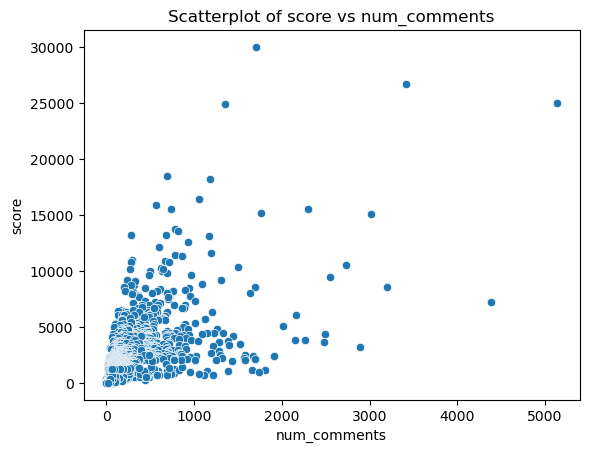

In [49]:
# Making scatterplot of the scores vs number of comments
sns.scatterplot(data=reddit_data, x='num_comments', y='score')
plt.title('Scatterplot of score vs num_comments');

In [50]:
# Making a function to get the top posts by title
def top_posts(df, value):
    top_title = []
    for i in range(value):
        top_title.append(df.title.value_counts().index[i])
    return top_title

In [51]:
# Using above function to call for top 5 posts
top_posts = top_posts(reddit_data, 5)
top_posts

["[Groundhog Day] Ned Ryerson is the devil, and he imprisons Phil Conners in the time loop when Phil refuses to purchase Ned's insurance. The only way Phil escapes is by finally agreeing to buy it.",
 'Teen from Oldham missing for six years found in France',
 'Batman never shows up to court',
 'What’s a case where you believe the person is alive/ being kept hostage/confined ?',
 'the protagonist of the 2011 drive movie did die at the end.']

In [52]:
# Creating a post_length column
reddit_data['post_length'] = reddit_data['self_text'].map(len)

In [53]:
# Creating a post_word_count column
reddit_data['post_word_count'] = reddit_data['self_text'].map(lambda x: len(x.split()))

In [54]:
# Creating a ratio of the post_length and post_word_length column
reddit_data['ratio'] = reddit_data.post_length/reddit_data.post_word_count

In [55]:
# Looking at the statistics of the three new columns
reddit_data[['post_length','post_word_count','ratio']].describe()

,post_length,post_word_count,ratio
count,4727.000000,4727.000000,4727.000000
mean,3673.393907,583.172625,6.261515
std,4684.897671,739.651010,1.866107
min,6.000000,1.000000,3.875000
25%,1082.000000,176.000000,5.618672
50%,2077.000000,330.000000,5.957096
75%,4253.500000,678.000000,6.533333
max,38584.000000,6586.000000,97.710145


In [56]:
# Top 10 Shortest post for reddit_data
reddit_data.sort_values(by='post_word_count', ascending=True)[['subreddit','post_word_count','post_length','ratio','self_text','score','num_comments']].head(10)

,subreddit,post_word_count,post_length,ratio,self_text,score,num_comments
4227,FanTheories,1,6,6.000000,Right?,1818,207
3836,FanTheories,3,12,4.000000,Which is it?,4532,131
1349,UnresolvedMysteries,5,83,16.600000,[Link can be found here](http://www.sacbee.com...,11641,1192
4335,FanTheories,7,33,4.714286,He succumbed to the sin of pride.,1672,171
3860,FanTheories,8,57,7.125000,A Demi-god's microaggression\n\nEdit: FULL god...,3723,144
4625,FanTheories,8,31,3.875000,He was made by a nine year old,1387,115
2291,UnresolvedMysteries,11,53,4.818182,"And yes, they did give credit to the DNA Doe p...",2032,210
4548,FanTheories,20,126,6.300000,I believe that neither Wolverine nor Deadpool ...,1437,139
2272,UnresolvedMysteries,21,625,29.761905,[Announcement](https://www.hollywoodreporter.c...,2061,136
1798,UnresolvedMysteries,22,127,5.772727,Husband: “ what are you looking up online?”\n\...,3004,415


In [57]:
# Top 10 Longest post for reddit_data
reddit_data.sort_values(by='post_word_count', ascending=False)[['subreddit','post_word_count','post_length','ratio','self_text','score','num_comments']].head(10)

,subreddit,post_word_count,post_length,ratio,self_text,score,num_comments
2319,UnresolvedMysteries,6586,38584,5.858488,"On August 18th 2010, [Ben McDaniel](https://im...",1997,521
1537,UnresolvedMysteries,6457,36279,5.618554,"March 2, 1978. An old woman lay in bed, but sh...",4277,303
1994,UnresolvedMysteries,6411,37699,5.880362,"On 30.06.2014, Lars Mittank flew with three fr...",2499,250
3793,FanTheories,6275,37864,6.034104,**This theory has a lot of evidence and took a...,10293,626
889,UnresolvedMysteries,5940,34575,5.820707,ETA: There should be a period at the end of th...,739,179
1788,UnresolvedMysteries,5915,34518,5.835672,I’ve been captivated by this one for a while. ...,3062,195
1356,UnresolvedMysteries,5729,35162,6.137546,"In Waidhofen, Germany, on the night of March 3...",10024,633
639,UnresolvedMysteries,5716,35580,6.224633,"Cloverdale, B.C. - On June 23, 2018 around 4 ...",116,7
3790,FanTheories,5691,37338,6.560886,**WARNING: SPOILERS ARE ALL OVER THIS THEORY L...,11322,864
451,UnresolvedMysteries,5565,36060,6.479784,International Day of Older Persons is held ann...,578,58


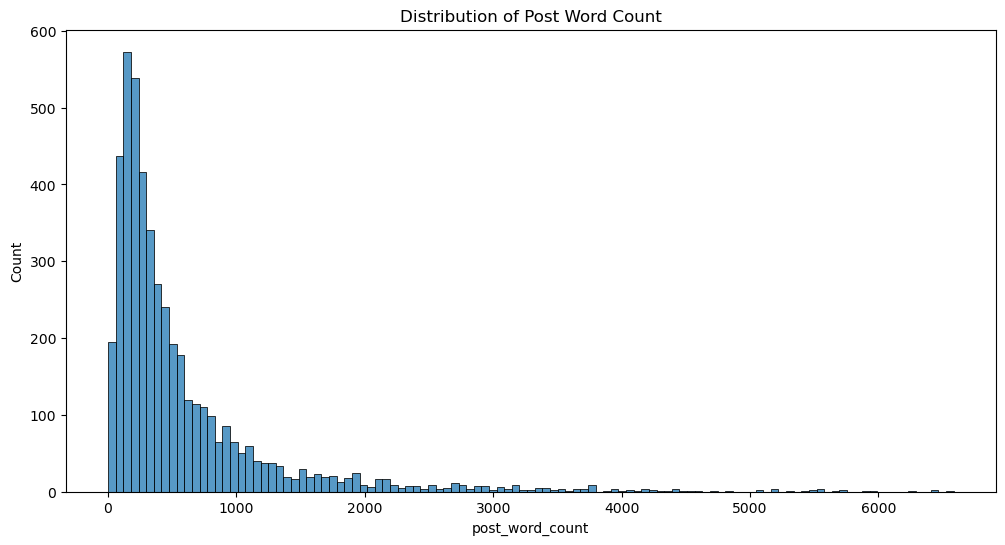

In [58]:
# Making histogram of post_word_count
plt.figure(figsize=(12,6))
sns.histplot(reddit_data['post_word_count'])
plt.title('Distribution of Post Word Count');

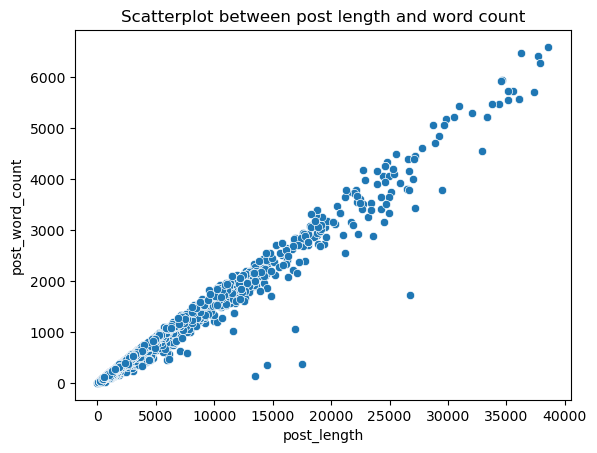

In [59]:
# Making scatterplot of post_length vs post_word_count
sns.scatterplot(data=reddit_data, x='post_length', y='post_word_count')
plt.title('Scatterplot between post length and word count');

In [60]:
# We will now use countvectorize to get top words
# Top 15 common words
# Got help with syntax from Tim as I was running into memory issues

sw = stopwords.words('english') + ['https', 'com', 'www', 'x200b', 'unresolvedmysteries', 'reddit', 'fantheories', 'org']

cv = CountVectorizer(stop_words = sw)
cv.fit(reddit_data['self_text'])

reddit_data_cv = cv.transform(reddit_data['self_text'])
reddit_data_df = pd.DataFrame(np.sum(reddit_data_cv, axis = 0), columns=cv.get_feature_names_out())

In [61]:
# Getting top 15 words
top_15_words = reddit_data_df.T.sort_values(0, ascending = False).head(15)
top_15_words

,0
would,8791
one,8447
case,7667
found,7298
time,7229
police,7223
also,6546
could,5152
family,5097
like,4915


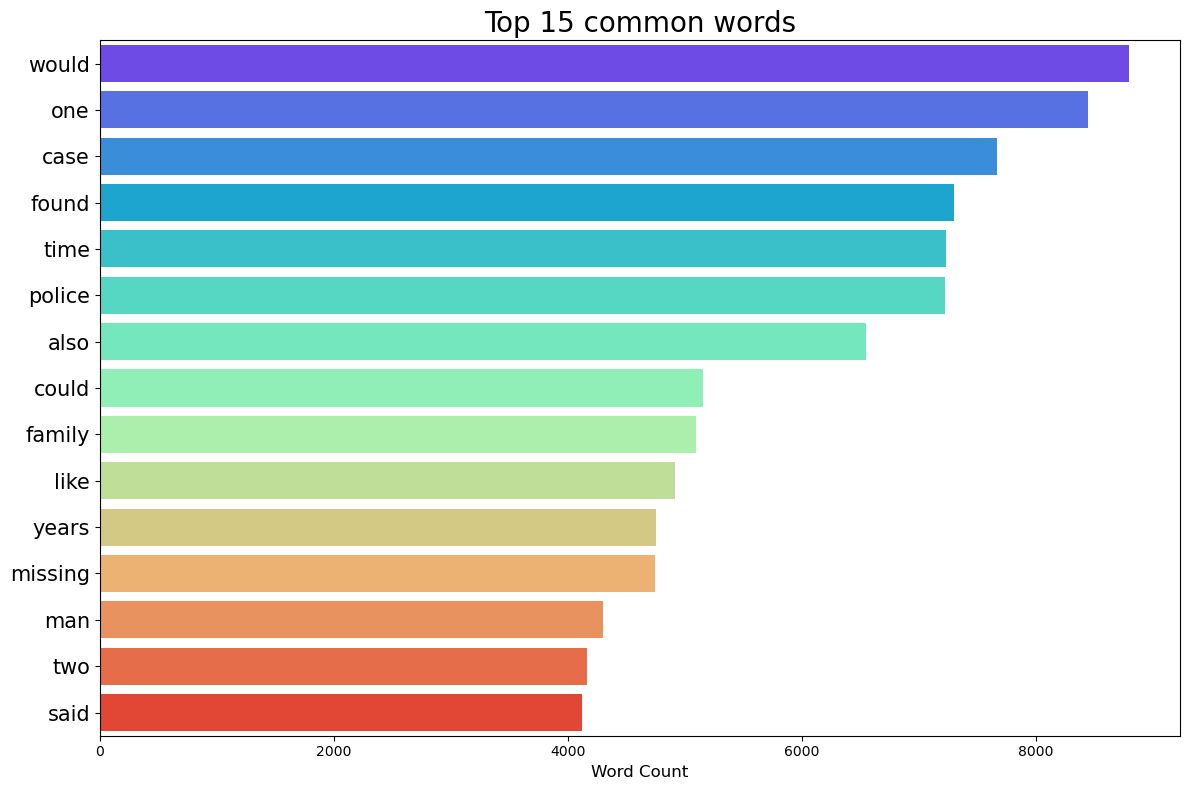

In [62]:
# Making barplot of the top 15 common words
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=0, y=top_15_words.index , data=top_15_words, palette = "rainbow")
plt.title('Top 15 common words',fontsize=20)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("Top_15_words.png");

In [63]:
# Looking at top 15 bigrams
cv_bigrams = CountVectorizer(ngram_range=(2, 2), stop_words=sw)
cv_bigrams.fit(reddit_data['self_text'])

bigrams_cv = cv_bigrams.transform(reddit_data['self_text'])
bigrams_df = pd.DataFrame(np.sum(bigrams_cv, axis = 0), columns=cv_bigrams.get_feature_names_out())

top_15_bigrams = bigrams_df.T.sort_values(0, ascending = False).head(15)
top_15_bigrams

,0
year old,2055
amp amp,882
last seen,874
wikipedia wiki,835
went missing,832
years old,831
en wikipedia,806
cold case,706
jane doe,701
charleyproject case,597


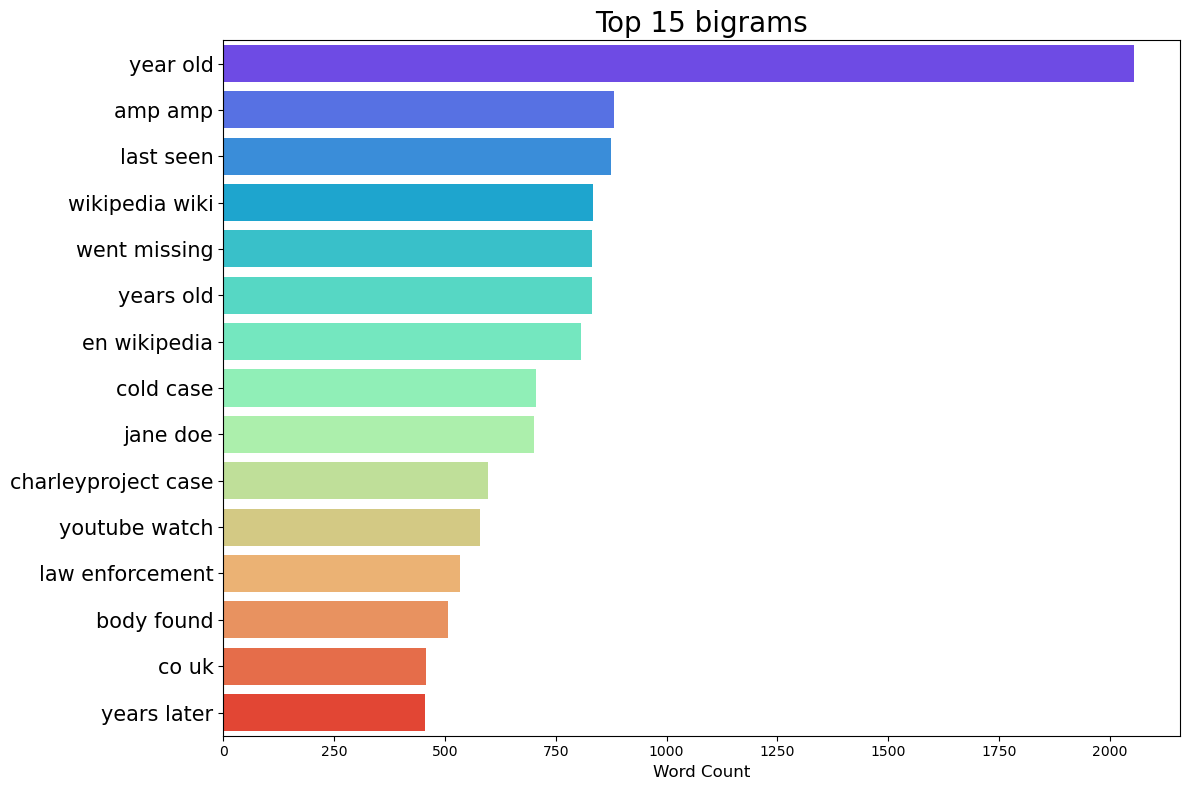

In [64]:
# Making a barplot of top 15 bigrams
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=0, y=top_15_bigrams.index , data=top_15_bigrams, palette = "rainbow")
plt.title('Top 15 bigrams',fontsize=20)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("Top_15_bigrams.png");

In [65]:
# Looking at top 15 trigrams
cv_trigrams = CountVectorizer(ngram_range=(3, 3), stop_words = sw)
cv_trigrams.fit(reddit_data['self_text'])

trigrams_cv = cv_trigrams.transform(reddit_data['self_text'])
trigrams_df = pd.DataFrame(np.sum(trigrams_cv, axis = 0), columns=cv_trigrams.get_feature_names_out())

top_15_trigrams = trigrams_df.T.sort_values(0, ascending = False).head(15)
top_15_trigrams

,0
en wikipedia wiki,804
amp amp amp,725
co uk news,304
county sheriff office,219
namus gov missingpersons,155
gov missingpersons case,155
unidentified awareness fandom,150
awareness fandom wiki,150
wp content uploads,136
namus gov unidentifiedpersons,134


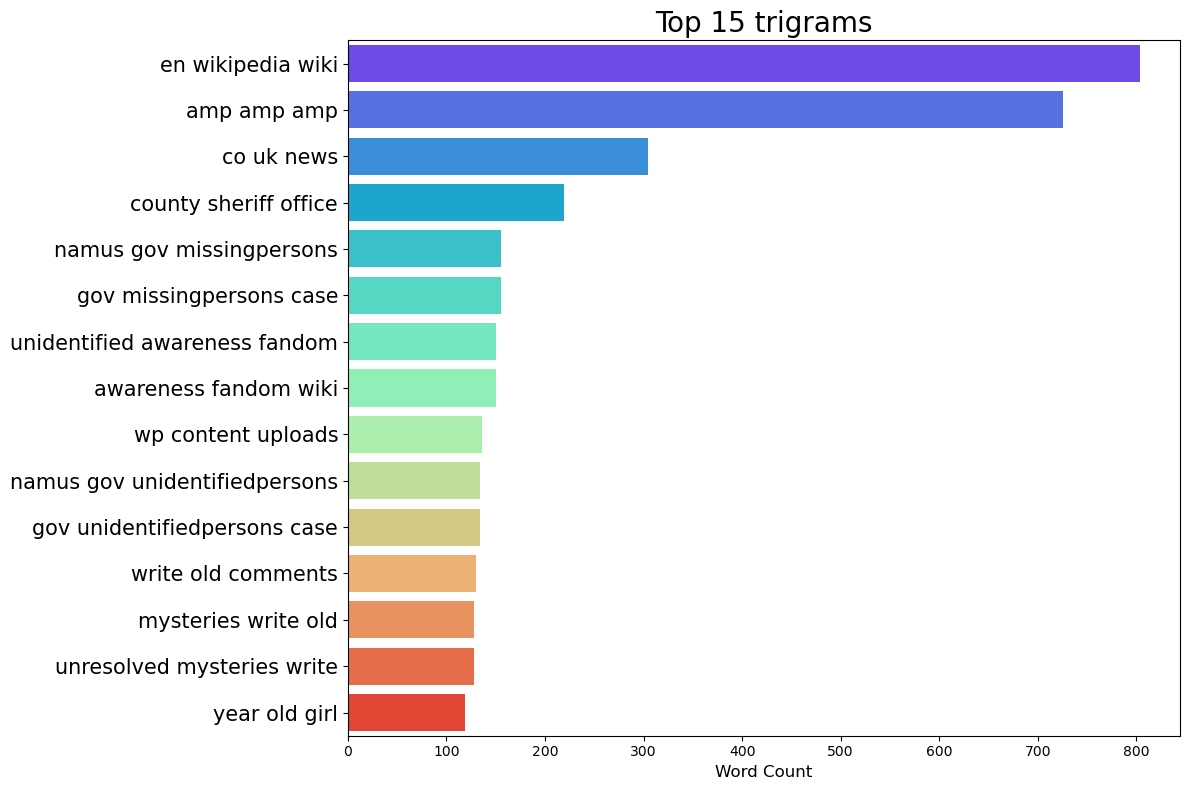

In [66]:
# Making a barplot of top 15 trigrams
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=0, y=top_15_trigrams.index , data=top_15_trigrams, palette = "rainbow")
plt.title('Top 15 trigrams',fontsize=20)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("Top_15_trigrams.png");

In [67]:
# Reminding myself of the columns in the dataset
reddit_data.columns

Index(['created_utc', 'title', 'self_text', 'subreddit', 'score',
       'num_comments', 'post_length', 'post_word_count', 'ratio'],
      dtype='object')

In [68]:
# We will now do a sentiment analysis
# Identify the columns needed for sentiment analysis
sent_df = reddit_data[['subreddit', 'self_text']]
sent_df.reset_index(drop=True, inplace=True)

In [69]:
# Looking at first 5 rows
sent_df.head()

,subreddit,self_text
0,UnresolvedMysteries,Ten-year-old Mary Ann Verdecchia was excited o...
1,UnresolvedMysteries,**Background** \nLisa Hession was a 14 year o...
2,UnresolvedMysteries,Saw this story online and thought it was worth...
3,UnresolvedMysteries,"I know this has been covered a few times, but ..."
4,UnresolvedMysteries,Hello everyone! Thank you for all your comment...


In [70]:
# Instantiate Sentiment Intensity Analyzer
sent = SentimentIntensityAnalyzer()

# Get the sentiment scores
sentiment = [sent.polarity_scores(i) for i in sent_df.self_text]

In [71]:
# Putting all of the scores in a dataframe
sent_score_df = pd.DataFrame(sentiment)
sent_score_df

,neg,neu,pos,compound
0,0.095,0.848,0.057,-0.9923
1,0.167,0.763,0.070,-0.9997
2,0.121,0.802,0.077,-0.9815
3,0.075,0.863,0.063,-0.9262
4,0.143,0.802,0.055,-0.9980
...,...,...,...,...
4722,0.039,0.835,0.126,0.9977
4723,0.091,0.752,0.157,0.8490
4724,0.163,0.733,0.104,-0.9616
4725,0.095,0.794,0.111,0.4659


In [72]:
# Combining columns with scores
sent_combine = pd.concat([sent_df, sent_score_df], axis=1)

In [73]:
# Create column 'overall' to get a rough understanding on the sentiments

sent_combine['overall'] = 'neu'
for index, row in enumerate(sent_combine['compound']):
    if row <= -0.05:
        sent_combine['overall'][index] = 'neg'
    elif row >= 0.05:
        sent_combine['overall'][index] = 'pos'

C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'neg'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'neg'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][i

C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'neg'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'neg'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][i

C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'neg'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'neg'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][i

C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'pos'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][index] = 'neg'
C:\Users\binit\AppData\Local\Temp\ipykernel_3488\3742564298.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_combine['overall'][i

In [74]:
# Look at the dataframe created
sent_combine

,subreddit,self_text,neg,neu,pos,compound,overall
0,UnresolvedMysteries,Ten-year-old Mary Ann Verdecchia was excited o...,0.095,0.848,0.057,-0.9923,neg
1,UnresolvedMysteries,**Background** \nLisa Hession was a 14 year o...,0.167,0.763,0.070,-0.9997,neg
2,UnresolvedMysteries,Saw this story online and thought it was worth...,0.121,0.802,0.077,-0.9815,neg
3,UnresolvedMysteries,"I know this has been covered a few times, but ...",0.075,0.863,0.063,-0.9262,neg
4,UnresolvedMysteries,Hello everyone! Thank you for all your comment...,0.143,0.802,0.055,-0.9980,neg
...,...,...,...,...,...,...,...
4722,FanTheories,"So by using my basic Chemistry knowledge, hint...",0.039,0.835,0.126,0.9977,pos
4723,FanTheories,"If one thing is consistent in Bob’s Burgers, i...",0.091,0.752,0.157,0.8490,pos
4724,FanTheories,Dr. Strange saw millions of possible futures a...,0.163,0.733,0.104,-0.9616,neg
4725,FanTheories,Before she went through the door she told mobi...,0.095,0.794,0.111,0.4659,pos


In [75]:
# Looking at the score means by each subreddit
sent_combine.groupby('subreddit').mean(numeric_only = True)

,neg,neu,pos,compound
subreddit,,,,
FanTheories,0.093767,0.815494,0.090747,-0.033897
UnresolvedMysteries,0.099146,0.842968,0.057874,-0.508258


In [76]:
# Getting proportion of the score categories by subreddit
reddit_data_sent_urm = sent_combine[sent_combine.subreddit=='UnresolvedMysteries']
reddit_data_sent_urm.overall.value_counts()*100/len(reddit_data_sent_urm)

overall
neg    74.784111
pos    24.740933
neu     0.474957
Name: count, dtype: float64

In [77]:
# Getting proportion of the score categories by subreddit
reddit_data_sent_ft = sent_combine[sent_combine.subreddit=='FanTheories']
reddit_data_sent_ft.overall.value_counts()*100/len(reddit_data_sent_ft)

overall
neg    50.933223
pos    47.573621
neu     1.493156
Name: count, dtype: float64

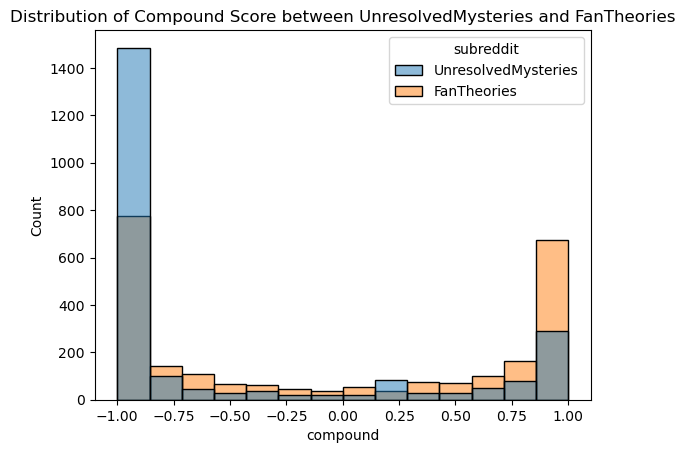

In [78]:
# Making histogram of compound score between the two subreddits
sns.histplot(data=sent_combine, x='compound', hue='subreddit')
plt.title('Distribution of Compound Score between UnresolvedMysteries and FanTheories')
plt.savefig("Sentiment_Analysis_compound_score.png");

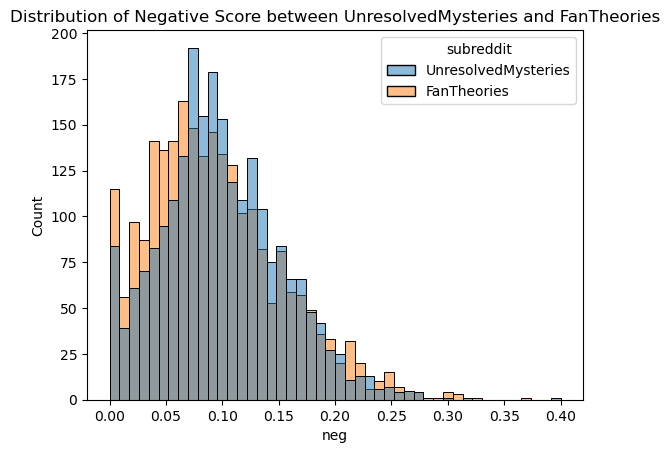

In [46]:
# Making histogram of negative score between the two subreddits
sns.histplot(data=sent_combine, x='neg', hue='subreddit')
plt.title('Distribution of Negative Score between UnresolvedMysteries and FanTheories');

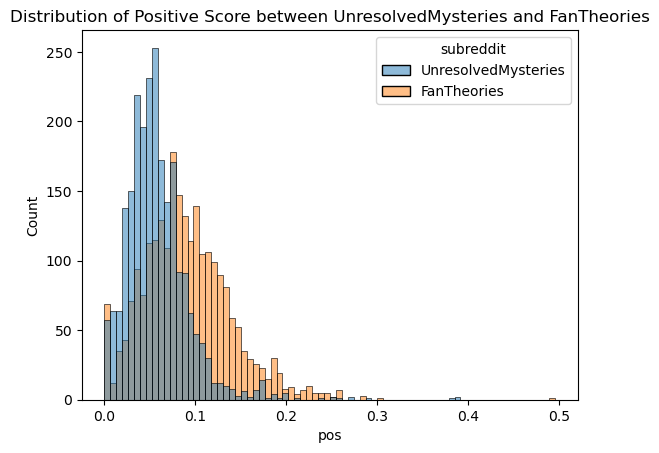

In [47]:
# Making histogram of positive score between the two subreddits
sns.histplot(data=sent_combine, x='pos', hue='subreddit')
plt.title('Distribution of Positive Score between UnresolvedMysteries and FanTheories');

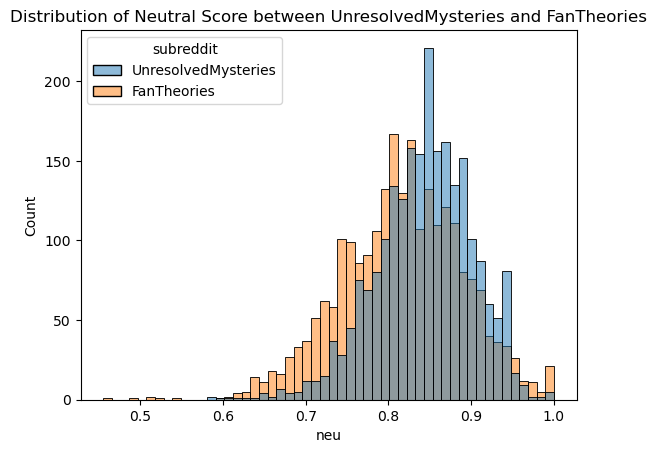

In [48]:
# Making histogram of neutral score between the two subreddits
sns.histplot(data=sent_combine, x='neu', hue='subreddit');
plt.title('Distribution of Neutral Score between UnresolvedMysteries and FanTheories');

## Write clean copy of dataset to use for preprocessing and modeling

In [49]:
# Subsetting data for the columns we will need for our preprocessing and model step
nlp_df = reddit_data[['subreddit', 'self_text']]

# Map subreddits to the respective binary
nlp_df['subreddit'] = nlp_df['subreddit'].map({'UnresolvedMysteries': 1, 'FanTheories': 0})
nlp_df

C:\Users\binit\AppData\Local\Temp\ipykernel_21964\326802896.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_df['subreddit'] = nlp_df['subreddit'].map({'UnresolvedMysteries': 1, 'FanTheories': 0})


,subreddit,self_text
0,1,Ten-year-old Mary Ann Verdecchia was excited o...
1,1,**Background** \nLisa Hession was a 14 year o...
2,1,Saw this story online and thought it was worth...
3,1,"I know this has been covered a few times, but ..."
4,1,Hello everyone! Thank you for all your comment...
...,...,...
4780,0,"So by using my basic Chemistry knowledge, hint..."
4781,0,"If one thing is consistent in Bob’s Burgers, i..."
4782,0,Dr. Strange saw millions of possible futures a...
4783,0,Before she went through the door she told mobi...


In [50]:
# Randomize the order
nlp_df = nlp_df.sample(frac=1, random_state = 2024).reset_index(drop=True)
nlp_df.head()

,subreddit,self_text
0,1,**MAJOR UPDATE: we have his name. Incredible r...
1,1,"On October 1, 2017, Stephen Paddock, a 64-year..."
2,1,Anny van der Groen-Heyligers was a 23 year old...
3,0,POTENTIAL SPOILERS AHEAD:\nSo an anonymous sou...
4,0,This has a Spoiler tag just in case nobody has...


In [51]:
# Export the main nlp_df into csv file for preprocessing and modeling
nlp_df.to_csv('./data/reddit_data_cleaned.csv', index=False)